In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
import datetime as dt
import time
import random

In [106]:
def score(x,num):
    if num>=1:
        return pd.qcut(x, num, labels=list(range(num)))
    if num<1:
        return pd.qcut(x, [0,num,1-num,1], labels=list(range(3)))
    
    
#需要用到外部变量rts
def next_return(df):
    cond=(rts.month==df['next_month'])&(rts.symbol==df['symbol'])
    x=rts.loc[cond]
    if len(x)!=0:
        return x['return'].values[0]
    else:
        return np.nan
    
def monthly_fct(fct_df): 
    df=fct_df.copy()
    for col in df.columns[1:].values:
        df[col]=df[col].apply(lambda x : 1+x)
        
    rlt=df.groupby('month',as_index=False).prod()
    
    for col in df.columns[1:].values:  
        rlt['cum_'+f'{col}']=rlt[col].cumprod()#累计收益率
        rlt[col]=rlt[col].apply(lambda x : x-1)#月收益率
#     for col in df.columns[1:].values:  
#         rlt['demean_'+f'{col}']=rlt[col]-rlt[col].mean()
    return rlt

In [22]:
rts=pd.read_csv('stocks_hs300_monthly.csv')
rts.drop(columns='Unnamed: 0',inplace=True)
rts

,month,symbol,return,pb,pe,cap,close,cum_12months
0,2008-10,000001.SZ,-0.271607,1.414580,5.87712,25992480588,313.4350,NaN
1,2008-10,000002.SZ,-0.099541,2.148670,21.29940,62165112619,623.9580,NaN
2,2008-10,000009.SZ,0.154321,2.283990,16.17730,3885149505,12.0899,NaN
3,2008-10,000012.SZ,-0.404785,1.615620,10.58650,6196258356,47.7997,NaN
4,2008-10,000021.SZ,-0.261476,0.971109,11.63200,3254218528,23.4903,NaN
...,...,...,...,...,...,...,...,...
41949,2020-07,603799.SH,0.100359,5.679970,66.48420,48800342852,79.0255,0.828913
41950,2020-07,603833.SH,0.091097,5.760860,-129.77100,52700568886,128.4070,0.216240
41951,2020-07,603899.SH,0.197254,13.678400,65.79090,60625942212,139.5100,NaN
41952,2020-07,603986.SH,-0.018693,20.031500,162.25800,108985720938,916.6070,2.317926


In [23]:
rts['pb_rank']=np.nan
rts['pe_rank']=np.nan
rts['cap_rank']=np.nan
rts['cum_rank']=np.nan
#double sort
rts['pb_rank2']=np.nan
rts['cap_rank2']=np.nan

In [24]:
#按各财务指标高低把当月的股票样本分类，为构建多空组合做准备
for mon in rts.month.unique():
    cond=rts.month==mon
    rts.loc[cond,'pb_rank']=score(rts.loc[cond,'pb'],0.3)
    rts.loc[cond,'pe_rank']=score(rts.loc[cond,'pe'],0.3)
    rts.loc[cond,'cap_rank']=score(rts.loc[cond,'cap'],0.3)
    if mon>='2009-10':#全是nan时，qcut无法处理
        rts.loc[cond,'cum_rank']=score(rts.loc[cond,'cum_12months'],0.3)
    rts.loc[cond,'pb_rank2']=score(rts.loc[cond,'pb'],4)

In [25]:
for mon in rts.month.unique():
    for rk in rts.pb_rank2.unique():
        cond=(rts.month==mon)&(rts.pb_rank2==rk)
        rts.loc[cond,'cap_rank2']=score(rts.loc[cond,'cap'],5)
rts  

,month,symbol,return,pb,pe,cap,close,cum_12months,pb_rank,pe_rank,cap_rank,cum_rank,pb_rank2,cap_rank2
0,2008-10,000001.SZ,-0.271607,1.414580,5.87712,25992480588,313.4350,NaN,1,0,2,NaN,1,4
1,2008-10,000002.SZ,-0.099541,2.148670,21.29940,62165112619,623.9580,NaN,2,2,2,NaN,2,4
2,2008-10,000009.SZ,0.154321,2.283990,16.17730,3885149505,12.0899,NaN,2,1,0,NaN,2,0
3,2008-10,000012.SZ,-0.404785,1.615620,10.58650,6196258356,47.7997,NaN,1,1,1,NaN,1,2
4,2008-10,000021.SZ,-0.261476,0.971109,11.63200,3254218528,23.4903,NaN,0,1,0,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41949,2020-07,603799.SH,0.100359,5.679970,66.48420,48800342852,79.0255,0.828913,2,2,0,2,2,1
41950,2020-07,603833.SH,0.091097,5.760860,-129.77100,52700568886,128.4070,0.216240,2,0,1,1,3,0
41951,2020-07,603899.SH,0.197254,13.678400,65.79090,60625942212,139.5100,NaN,2,2,1,NaN,3,1
41952,2020-07,603986.SH,-0.018693,20.031500,162.25800,108985720938,916.6070,2.317926,2,2,1,2,3,2


In [45]:
month_arr=np.append(rts.month.unique(),['2020-08'],-1)

In [48]:
rts['next_month']=rts['month'].apply(lambda x:month_arr[np.where(month_arr == x)[0][0]+1])

In [64]:
rts['next_return']=np.nan

In [69]:
t1=time.time()
rts['next_return']=rts.apply(next_return,axis=1)
t2=time.time()
t2-t1

272.2091143131256

In [81]:
rts.to_csv('rts_hs300_next_return.csv')
rts

,month,symbol,return,pb,pe,cap,close,cum_12months,pb_rank,pe_rank,cap_rank,cum_rank,pb_rank2,cap_rank2,next_month,next_return
0,2008-10,000001.SZ,-0.271607,1.414580,5.87712,25992480588,313.4350,NaN,1,0,2,NaN,1,4,2008-11,0.074076
1,2008-10,000002.SZ,-0.099541,2.148670,21.29940,62165112619,623.9580,NaN,2,2,2,NaN,2,4,2008-11,0.159865
2,2008-10,000009.SZ,0.154321,2.283990,16.17730,3885149505,12.0899,NaN,2,1,0,NaN,2,0,2008-11,0.139042
3,2008-10,000012.SZ,-0.404785,1.615620,10.58650,6196258356,47.7997,NaN,1,1,1,NaN,1,2,2008-11,0.184888
4,2008-10,000021.SZ,-0.261476,0.971109,11.63200,3254218528,23.4903,NaN,0,1,0,NaN,0,1,2008-11,0.132429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41949,2020-07,603799.SH,0.100359,5.679970,66.48420,48800342852,79.0255,0.828913,2,2,0,2,2,1,2020-08,NaN
41950,2020-07,603833.SH,0.091097,5.760860,-129.77100,52700568886,128.4070,0.216240,2,0,1,1,3,0,2020-08,NaN
41951,2020-07,603899.SH,0.197254,13.678400,65.79090,60625942212,139.5100,NaN,2,2,1,NaN,3,1,2020-08,NaN
41952,2020-07,603986.SH,-0.018693,20.031500,162.25800,108985720938,916.6070,2.317926,2,2,1,2,3,2,2020-08,NaN


In [90]:
fcts=['pb_rank','pe_rank','cap_rank','cum_rank']
for col in fcts:
    fct_tmp=rts.groupby(['month',col],as_index=False)['next_return'].mean()
    fct_tmp[col]=(fct_tmp[col]-1)/2*fct_tmp['next_return']
    fct_tmp=fct_tmp.groupby(['month'],as_index=False)[col].sum()
    if col==fcts[0]:
        fct_rts=fct_tmp
    else:
        fct_rts = pd.merge(fct_rts, fct_tmp, on='month',how='outer')
fct_rts.rename(columns={'pb_rank':'hml','pe_rank':'rmw','cap_rank':'smb','cum_rank':'umd'},inplace=True)
fct_rts

,month,hml,rmw,smb,umd
0,2008-10,-0.031251,-0.000007,-0.040688,NaN
1,2008-11,0.014633,0.000120,-0.018691,NaN
2,2008-12,-0.035033,-0.022995,-0.051116,NaN
3,2009-01,-0.008230,0.008879,-0.029665,NaN
4,2009-02,0.011818,-0.003920,-0.014399,NaN
...,...,...,...,...,...
137,2020-03,0.045918,0.016647,0.014592,0.037295
138,2020-04,0.020355,0.003641,-0.011202,0.000517
139,2020-05,0.055984,0.030677,0.021218,0.061009
140,2020-06,0.012948,-0.000332,-0.026548,0.017898


In [91]:
#计算因子的累积收益率
for col in fct_rts.columns[1:].values:
    fct_rts[col]=fct_rts[col]+1
    fct_rts['cum_'+f'{col}']=fct_rts[col].cumprod()#累计收益率
    fct_rts[col]=fct_rts[col]-1
fct_rts=fct_rts.iloc[:-1]
fct_rts

,month,hml,rmw,smb,umd,cum_hml,cum_rmw,cum_smb,cum_umd
0,2008-10,-0.031251,-0.000007,-0.040688,NaN,0.968749,0.999993,0.959312,NaN
1,2008-11,0.014633,0.000120,-0.018691,NaN,0.982925,1.000112,0.941381,NaN
2,2008-12,-0.035033,-0.022995,-0.051116,NaN,0.948490,0.977114,0.893261,NaN
3,2009-01,-0.008230,0.008879,-0.029665,NaN,0.940683,0.985790,0.866763,NaN
4,2009-02,0.011818,-0.003920,-0.014399,NaN,0.951800,0.981926,0.854283,NaN
...,...,...,...,...,...,...,...,...,...
136,2020-02,-0.016994,-0.011347,0.001368,-0.012419,0.726963,0.516401,0.772366,1.284576
137,2020-03,0.045918,0.016647,0.014592,0.037295,0.760343,0.524997,0.783636,1.332485
138,2020-04,0.020355,0.003641,-0.011202,0.000517,0.775820,0.526909,0.774858,1.333173
139,2020-05,0.055984,0.030677,0.021218,0.061009,0.819253,0.543073,0.791299,1.414508


In [94]:
fct_rts['month']=fct_rts['month'].apply(lambda x:month_arr[np.where(month_arr == x)[0][0]+1])
fct_rts

/Users/sexin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,month,hml,rmw,smb,umd,cum_hml,cum_rmw,cum_smb,cum_umd
0,2008-11,-0.031251,-0.000007,-0.040688,NaN,0.968749,0.999993,0.959312,NaN
1,2008-12,0.014633,0.000120,-0.018691,NaN,0.982925,1.000112,0.941381,NaN
2,2009-01,-0.035033,-0.022995,-0.051116,NaN,0.948490,0.977114,0.893261,NaN
3,2009-02,-0.008230,0.008879,-0.029665,NaN,0.940683,0.985790,0.866763,NaN
4,2009-03,0.011818,-0.003920,-0.014399,NaN,0.951800,0.981926,0.854283,NaN
...,...,...,...,...,...,...,...,...,...
136,2020-03,-0.016994,-0.011347,0.001368,-0.012419,0.726963,0.516401,0.772366,1.284576
137,2020-04,0.045918,0.016647,0.014592,0.037295,0.760343,0.524997,0.783636,1.332485
138,2020-05,0.020355,0.003641,-0.011202,0.000517,0.775820,0.526909,0.774858,1.333173
139,2020-06,0.055984,0.030677,0.021218,0.061009,0.819253,0.543073,0.791299,1.414508


<AxesSubplot:>

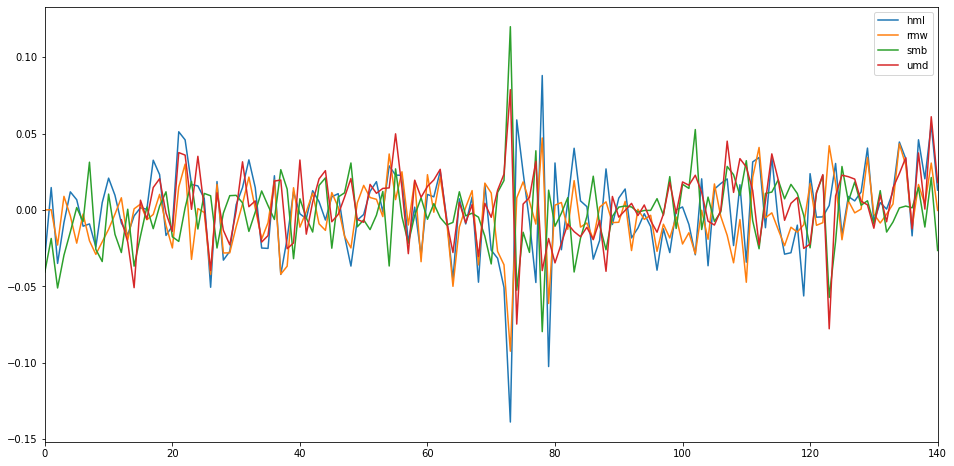

In [92]:
fct_rts.iloc[:][fct_rts.columns[1:5]].plot(figsize=(16,8),legend=True)

<AxesSubplot:>

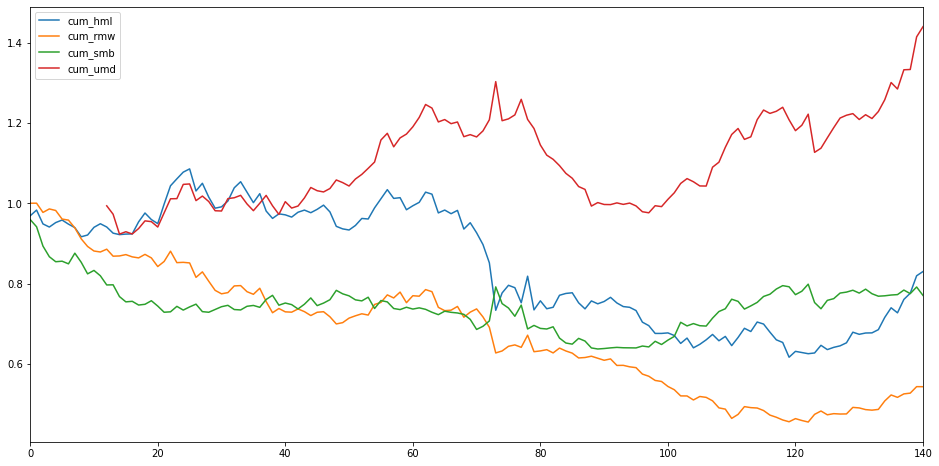

In [93]:
fct_rts.iloc[:][fct_rts.columns[5:]].plot(figsize=(16,8),legend=True)

In [95]:
fct_rts.to_csv('fama_fcts_next_month.csv')

In [97]:
#double sort之后得到的各资产等权月度收益率
ass_tmp=rts.groupby(['month','pb_rank2','cap_rank2'],as_index=False)['next_return'].mean()
ass_tmp

,month,pb_rank2,cap_rank2,next_return
0,2008-10,0,0,0.181660
1,2008-10,0,1,0.250744
2,2008-10,0,2,0.168936
3,2008-10,0,3,0.216017
4,2008-10,0,4,0.208095
...,...,...,...,...
2835,2020-07,3,0,NaN
2836,2020-07,3,1,NaN
2837,2020-07,3,2,NaN
2838,2020-07,3,3,NaN


In [100]:
#将其转为更标准的数据块
assets=pd.DataFrame({})
assets['month']=pd.Series(ass_tmp['month'].unique())
for i in range(len(ass_tmp.pb_rank2.unique())):
    for j in range(len(ass_tmp.cap_rank2.unique())):
        asset0=ass_tmp.loc[(ass_tmp.pb_rank2==i)&(ass_tmp.cap_rank2==j)].sort_values('month')
        asset0.index=np.array(range(len(asset0)))
        assets['asset_'+f'{i}'+f'{j}']=asset0['next_return']
assets

,month,asset_00,asset_01,asset_02,asset_03,asset_04,asset_10,asset_11,asset_12,asset_13,...,asset_20,asset_21,asset_22,asset_23,asset_24,asset_30,asset_31,asset_32,asset_33,asset_34
0,2008-10,0.181660,0.250744,0.168936,0.216017,0.208095,0.246086,0.185462,0.122670,0.136907,...,0.187693,0.143128,0.124231,0.093142,0.106251,0.140812,0.137553,0.168864,0.179914,0.051431
1,2008-11,0.015306,-0.021506,0.044986,-0.018529,-0.042193,0.002682,0.019621,0.013374,0.013188,...,0.056676,0.011691,0.025970,0.070760,-0.031025,0.057914,0.027911,0.046257,0.026835,-0.046689
2,2008-12,0.205497,0.209716,0.185721,0.165014,0.157118,0.221011,0.165971,0.173333,0.177359,...,0.266897,0.212433,0.180930,0.151271,0.071271,0.171287,0.145636,0.144700,0.091962,0.019763
3,2009-01,0.179261,0.077565,0.065527,0.093092,0.048649,0.103778,0.074794,0.051498,0.095088,...,0.089060,0.078886,0.044135,0.054359,0.011284,0.086671,0.112624,0.058061,0.092144,0.087602
4,2009-02,0.211800,0.196934,0.161593,0.190241,0.185991,0.204958,0.193098,0.210660,0.214519,...,0.208375,0.246124,0.318556,0.198476,0.159478,0.234159,0.234149,0.220355,0.186987,0.157662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2020-03,0.011026,0.000064,0.009871,0.015799,0.008614,0.029184,0.004249,-0.004773,-0.008536,...,0.008742,0.037185,0.075594,0.111980,0.080255,0.077766,0.148181,0.085355,0.098583,0.090412
138,2020-04,-0.008110,-0.019444,-0.012854,-0.027738,-0.026574,-0.011865,-0.018813,-0.028644,-0.044458,...,0.036277,0.009002,-0.025042,-0.019001,-0.016083,0.020149,0.050197,0.008768,0.012836,0.004677
139,2020-05,0.016290,0.015153,0.067928,0.006881,-0.004260,0.012225,0.046946,0.053931,0.051082,...,-0.004699,0.065337,0.082125,0.140433,0.066661,0.121633,0.136398,0.151265,0.149988,0.186250
140,2020-06,0.253369,0.122980,0.146484,0.072712,0.028602,0.183275,0.195360,0.229811,0.118816,...,0.170103,0.181611,0.175559,0.193354,0.110498,0.071849,0.138364,0.150806,0.224638,0.185797


In [101]:
assets=assets.iloc[:-1]
assets['month']=assets['month'].apply(lambda x:month_arr[np.where(month_arr == x)[0][0]+1])
#计算各资产的累积收益率
for col in assets.columns[1:].values:
    assets[col]=assets[col]+1
    assets['cum_'+f'{col}']=assets[col].cumprod()#累计收益率
    assets[col]=assets[col]-1
assets

/Users/sexin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sexin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/sexin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,month,asset_00,asset_01,asset_02,asset_03,asset_04,asset_10,asset_11,asset_12,asset_13,...,cum_asset_20,cum_asset_21,cum_asset_22,cum_asset_23,cum_asset_24,cum_asset_30,cum_asset_31,cum_asset_32,cum_asset_33,cum_asset_34
0,2008-11,0.181660,0.250744,0.168936,0.216017,0.208095,0.246086,0.185462,0.122670,0.136907,...,1.187693,1.143128,1.124231,1.093142,1.106251,1.140812,1.137553,1.168864,1.179914,1.051431
1,2008-12,0.015306,-0.021506,0.044986,-0.018529,-0.042193,0.002682,0.019621,0.013374,0.013188,...,1.255007,1.156492,1.153428,1.170492,1.071930,1.206881,1.169303,1.222932,1.211577,1.002340
2,2009-01,0.205497,0.209716,0.185721,0.165014,0.157118,0.221011,0.165971,0.173333,0.177359,...,1.589964,1.402169,1.362118,1.347553,1.148327,1.413605,1.339596,1.399890,1.322997,1.022150
3,2009-02,0.179261,0.077565,0.065527,0.093092,0.048649,0.103778,0.074794,0.051498,0.095088,...,1.731567,1.512780,1.422235,1.420805,1.161285,1.536123,1.490467,1.481169,1.444903,1.111692
4,2009-03,0.211800,0.196934,0.161593,0.190241,0.185991,0.204958,0.193098,0.210660,0.214519,...,2.092381,1.885112,1.875295,1.702801,1.346484,1.895819,1.839458,1.807552,1.715081,1.286964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,2020-03,-0.047706,-0.047251,-0.033697,-0.050241,-0.040515,-0.045613,-0.092922,-0.046606,-0.055552,...,2.724411,2.023932,1.906985,2.811126,1.118572,3.320046,2.247278,2.188047,2.424749,1.304873
137,2020-04,0.011026,0.000064,0.009871,0.015799,0.008614,0.029184,0.004249,-0.004773,-0.008536,...,2.748227,2.099191,2.051142,3.125917,1.208343,3.578234,2.580283,2.374807,2.663788,1.422849
138,2020-05,-0.008110,-0.019444,-0.012854,-0.027738,-0.026574,-0.011865,-0.018813,-0.028644,-0.044458,...,2.847924,2.118088,1.999778,3.066523,1.188909,3.650332,2.709805,2.395629,2.697980,1.429503
139,2020-06,0.016290,0.015153,0.067928,0.006881,-0.004260,0.012225,0.046946,0.053931,0.051082,...,2.834540,2.256477,2.164010,3.497164,1.268163,4.094331,3.079416,2.758004,3.102644,1.695749


<AxesSubplot:>

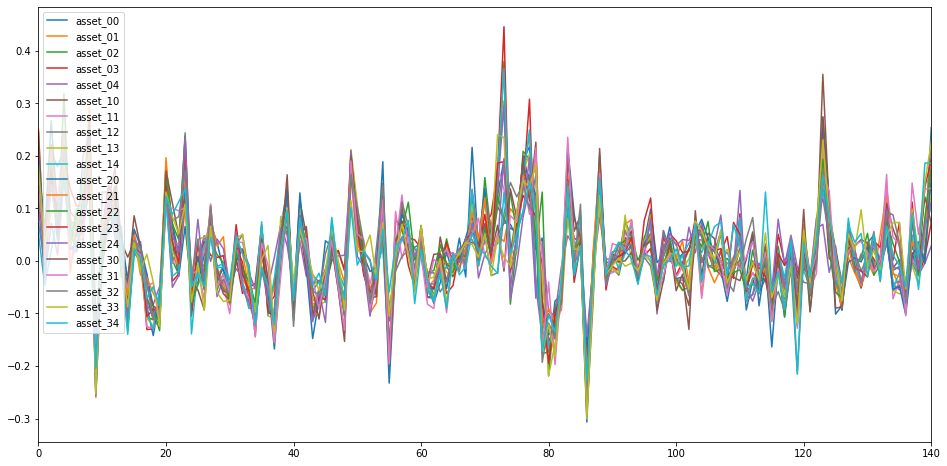

In [102]:
assets.iloc[:][assets.columns[1:21]].plot(figsize=(16,8),legend=True)

<AxesSubplot:>

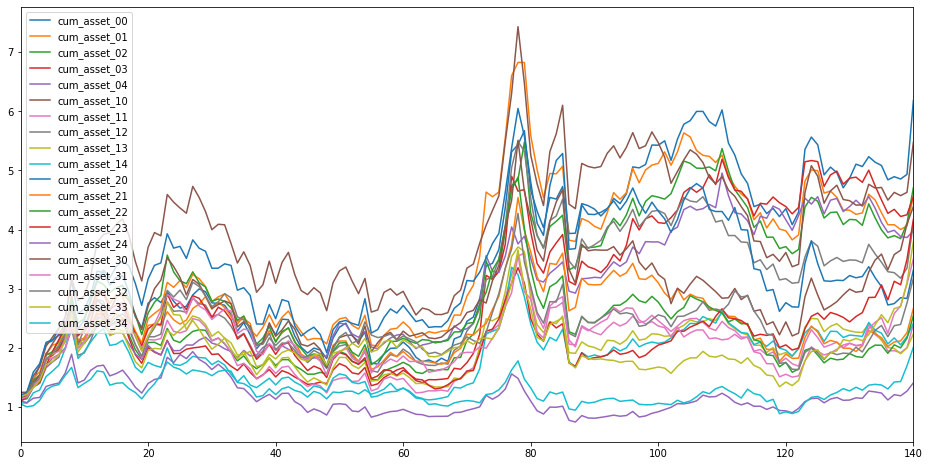

In [103]:
assets.iloc[:][assets.columns[21:]].plot(figsize=(16,8),legend=True)

<AxesSubplot:>

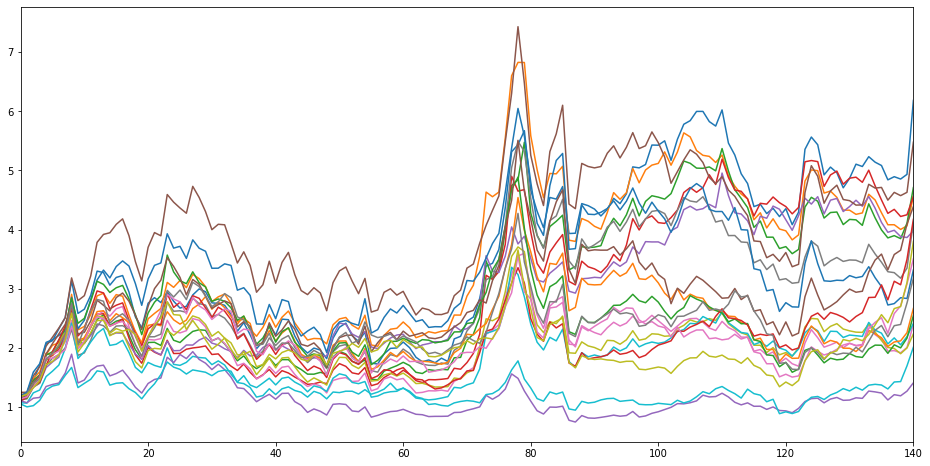

In [109]:
assets.iloc[:][assets.columns[21:]].plot(figsize=(16,8),legend=False)

In [104]:
assets.to_csv('assets_next_month.csv')

In [ ]:
#处理barra因子数据------------------------------------------------------

In [105]:
#读入原始barra因子数据
barra=pd.read_csv('factor_return.csv',parse_dates=['date'],dayfirst=True).loc[1:]#去掉不全的2005-04
barra

,date,country,beta,value,growth,momentum,size,leverage,earnings,liquidity,...,materials,industrials,consumer_discretionary,consumer_staples,health_care,financials,information,telecom,utilities,real_estate
1,2005-05-09,-0.025235,-0.004499,-0.005717,-0.001788,-0.006616,0.007494,-0.004329,0.004410,-0.001481,...,0.003580,-0.009070,0.000731,0.000675,0.010969,-0.000509,-0.009816,0.013683,0.009606,-0.011932
2,2005-05-10,0.004032,0.002804,0.002563,0.002258,-0.002535,0.005936,-0.000957,0.004053,0.002004,...,-0.004257,0.001177,0.000426,0.003335,-0.003052,0.013671,0.011296,-0.000855,-0.011818,0.012132
3,2005-05-11,-0.010895,-0.000960,-0.001781,-0.003284,-0.009055,0.001012,-0.000022,0.002422,-0.003148,...,0.001097,-0.002427,0.000135,0.002829,-0.005701,-0.004890,0.010643,0.009250,-0.002147,0.006721
4,2005-05-12,-0.016432,0.000839,-0.003444,0.001341,-0.006721,-0.005451,0.003571,-0.002469,-0.002494,...,0.003332,0.002551,0.007067,0.004407,-0.002533,-0.013549,0.000641,0.012797,-0.004998,-0.004274
5,2005-05-13,0.001933,-0.000605,-0.000393,-0.000145,-0.004084,-0.003465,0.000426,-0.001035,-0.000214,...,0.002949,0.002588,0.005697,-0.002287,0.009783,-0.002832,0.015878,-0.000387,-0.000587,-0.027532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3705,2020-07-27,0.004555,-0.000476,-0.000409,-0.000213,-0.002681,0.000353,-0.003608,-0.003580,-0.001963,...,0.017771,-0.010784,-0.002236,0.002758,0.015389,-0.001808,0.004363,-0.005979,0.004233,-0.013638
3706,2020-07-28,0.007811,0.000388,-0.002822,-0.001011,0.003851,-0.001719,-0.001025,0.004177,-0.000618,...,0.002986,0.003628,-0.010187,0.020842,-0.008248,-0.004053,-0.004684,0.003581,-0.001369,-0.005673
3707,2020-07-29,0.023977,0.006798,0.000213,0.000407,0.002901,-0.001743,0.001286,-0.002650,0.000186,...,-0.014344,-0.005263,0.010671,-0.016977,0.010219,0.007582,0.001463,-0.003858,-0.009084,-0.008793
3708,2020-07-30,-0.004785,-0.001547,0.003246,0.001035,0.000051,-0.001495,-0.002833,0.000631,-0.000858,...,0.001165,0.004948,-0.003643,0.014256,0.011806,-0.004906,-0.006763,-0.015555,0.002601,0.004908


In [107]:
barra['date']=barra.date.apply(lambda x: dt.datetime.strftime(x,'%Y-%m'))
barra.rename(columns={'date': 'month'},inplace=True)
#计算因子收益率的月频
barra=monthly_fct(barra)
barra

,month,country,beta,value,growth,momentum,size,leverage,earnings,liquidity,...,cum_materials,cum_industrials,cum_consumer_discretionary,cum_consumer_staples,cum_health_care,cum_financials,cum_information,cum_telecom,cum_utilities,cum_real_estate
0,2005-05,-0.084011,-0.016308,0.000516,-0.010810,-0.058812,-0.014709,0.001442,0.008021,-0.001592,...,1.011321,1.004651,1.030788,1.031867,1.018347,0.991784,1.044654,1.000316,0.969476,0.992112
1,2005-06,0.008757,-0.011878,-0.005379,-0.001064,0.014213,0.015391,-0.004848,-0.002003,0.005126,...,1.006788,0.986874,1.036704,1.034877,0.985456,1.016394,1.034962,1.022893,1.003450,1.001367
2,2005-07,-0.011751,-0.002583,0.002416,0.009663,0.011548,0.050924,-0.007994,0.004136,0.017468,...,0.993993,0.983139,1.025879,1.040967,0.989937,1.071645,1.015991,1.035498,1.016668,1.049670
3,2005-08,0.055754,0.034267,0.004633,0.009446,-0.027481,-0.017377,0.005495,-0.013354,-0.023230,...,0.976569,0.979152,1.017507,1.061475,1.003011,1.060970,1.036651,1.064404,1.030283,1.047703
4,2005-09,-0.002458,-0.002978,-0.020718,0.016477,-0.009207,-0.022967,-0.000758,-0.000779,-0.010510,...,0.990022,0.970938,1.014291,1.028896,0.965998,1.063196,0.996227,1.038421,1.025623,1.081467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,2020-03,-0.065049,-0.026713,0.014088,-0.001401,0.006967,-0.012770,-0.008808,-0.005013,-0.010256,...,0.600697,0.743090,1.196283,3.919580,1.975512,0.858312,1.019875,1.255073,0.483421,1.845133
179,2020-04,0.044611,-0.005549,-0.009801,0.016960,0.020920,0.001306,-0.003770,-0.005884,0.005191,...,0.592163,0.759885,1.183638,3.974717,2.037443,0.848389,1.030453,1.276144,0.478479,1.843362
180,2020-05,-0.011744,-0.007021,-0.005399,0.003368,0.004459,-0.005367,-0.000623,-0.012987,-0.000934,...,0.600602,0.746474,1.225648,4.091398,2.092207,0.840603,1.002438,1.278420,0.472235,1.822181
181,2020-06,0.067942,0.041438,-0.000674,-0.001174,0.017271,0.008502,0.009416,-0.009755,-0.017208,...,0.592377,0.721958,1.205712,4.097380,2.272653,0.827220,1.063403,1.313328,0.477775,1.810516


In [108]:
factors = pd.merge(barra,fct_rts, on='month',how='outer')
factors.to_csv('factors_hs300.csv')
factors

,month,country,beta,value,growth,momentum,size,leverage,earnings,liquidity,...,cum_utilities,cum_real_estate,hml,rmw,smb,umd,cum_hml,cum_rmw,cum_smb,cum_umd
0,2005-05,-0.084011,-0.016308,0.000516,-0.010810,-0.058812,-0.014709,0.001442,0.008021,-0.001592,...,0.969476,0.992112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-06,0.008757,-0.011878,-0.005379,-0.001064,0.014213,0.015391,-0.004848,-0.002003,0.005126,...,1.003450,1.001367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-07,-0.011751,-0.002583,0.002416,0.009663,0.011548,0.050924,-0.007994,0.004136,0.017468,...,1.016668,1.049670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-08,0.055754,0.034267,0.004633,0.009446,-0.027481,-0.017377,0.005495,-0.013354,-0.023230,...,1.030283,1.047703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-09,-0.002458,-0.002978,-0.020718,0.016477,-0.009207,-0.022967,-0.000758,-0.000779,-0.010510,...,1.025623,1.081467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,2020-03,-0.065049,-0.026713,0.014088,-0.001401,0.006967,-0.012770,-0.008808,-0.005013,-0.010256,...,0.483421,1.845133,-0.016994,-0.011347,0.001368,-0.012419,0.726963,0.516401,0.772366,1.284576
179,2020-04,0.044611,-0.005549,-0.009801,0.016960,0.020920,0.001306,-0.003770,-0.005884,0.005191,...,0.478479,1.843362,0.045918,0.016647,0.014592,0.037295,0.760343,0.524997,0.783636,1.332485
180,2020-05,-0.011744,-0.007021,-0.005399,0.003368,0.004459,-0.005367,-0.000623,-0.012987,-0.000934,...,0.472235,1.822181,0.020355,0.003641,-0.011202,0.000517,0.775820,0.526909,0.774858,1.333173
181,2020-06,0.067942,0.041438,-0.000674,-0.001174,0.017271,0.008502,0.009416,-0.009755,-0.017208,...,0.477775,1.810516,0.055984,0.030677,0.021218,0.061009,0.819253,0.543073,0.791299,1.414508


In [121]:
factors.columns[1:13]

Index(['country', 'beta', 'value', 'growth', 'momentum', 'size', 'leverage',
       'earnings', 'liquidity', 'nlsize', 'residualvolatility', 'dividend'],
      dtype='object')

<AxesSubplot:>

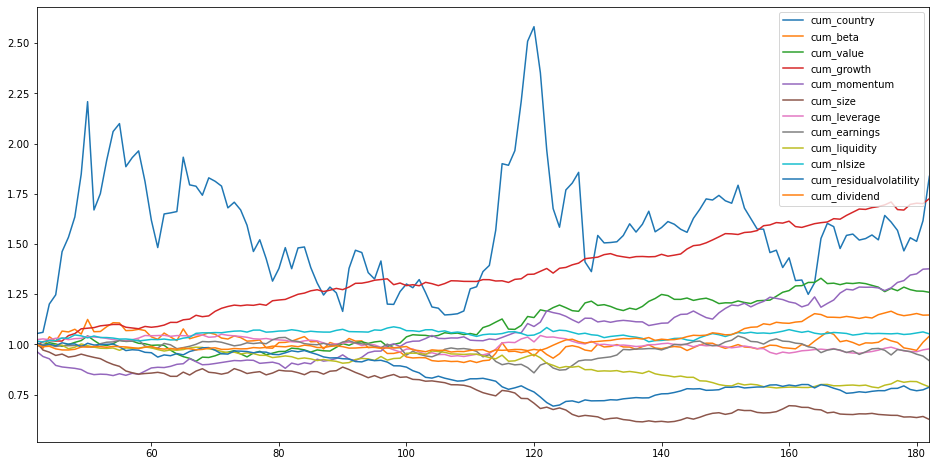

In [123]:
fct_plt2[fct_plt2.columns[-12:]].plot(figsize=(16,8),legend=True)

<AxesSubplot:>

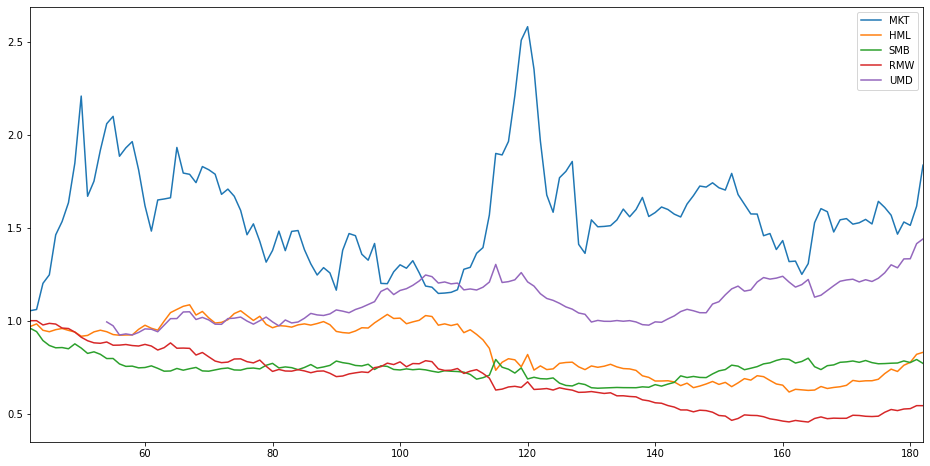

In [114]:
fct_plt[fct_plt.columns[-5:]].plot(figsize=(16,8),legend=True)

In [112]:
#计算因子的累积收益率
fct_plt=factors.iloc[42:][['month','country','hml','smb','rmw','umd']]
for col in fct_plt.columns[1:].values:
    fct_plt[col]=fct_plt[col]+1
    fct_plt['cum_'+f'{col}']=fct_plt[col].cumprod()#累计收益率
    fct_plt[col]=fct_plt[col]-1
fct_plt.rename(columns={'cum_country':'MKT','cum_hml':'HML','cum_smb':'SMB','cum_rmw':'RMW','cum_umd':'UMD'},inplace=True)
fct_plt

,month,country,hml,smb,rmw,umd,MKT,HML,SMB,RMW,UMD
42,2008-11,0.053872,-0.031251,-0.040688,-0.000007,NaN,1.053872,0.968749,0.959312,0.999993,NaN
43,2008-12,0.006135,0.014633,-0.018691,0.000120,NaN,1.060337,0.982925,0.941381,1.000112,NaN
44,2009-01,0.132729,-0.035033,-0.051116,-0.022995,NaN,1.201075,0.948490,0.893261,0.977114,NaN
45,2009-02,0.038165,-0.008230,-0.029665,0.008879,NaN,1.246914,0.940683,0.866763,0.985790,NaN
46,2009-03,0.172395,0.011818,-0.014399,-0.003920,NaN,1.461875,0.951800,0.854283,0.981926,NaN
...,...,...,...,...,...,...,...,...,...,...,...
178,2020-03,-0.065049,-0.016994,0.001368,-0.011347,-0.012419,1.465655,0.726963,0.772366,0.516401,1.284576
179,2020-04,0.044611,0.045918,0.014592,0.016647,0.037295,1.531039,0.760343,0.783636,0.524997,1.332485
180,2020-05,-0.011744,0.020355,-0.011202,0.003641,0.000517,1.513058,0.775820,0.774858,0.526909,1.333173
181,2020-06,0.067942,0.055984,0.021218,0.030677,0.061009,1.615858,0.819253,0.791299,0.543073,1.414508


In [122]:
#计算因子的累积收益率
fct_plt2=factors.iloc[42:][factors.columns[:13]]
for col in fct_plt2.columns[1:].values:
    fct_plt2[col]=fct_plt2[col]+1
    fct_plt2['cum_'+f'{col}']=fct_plt2[col].cumprod()#累计收益率
    fct_plt2[col]=fct_plt2[col]-1
fct_plt2

,month,country,beta,value,growth,momentum,size,leverage,earnings,liquidity,...,cum_value,cum_growth,cum_momentum,cum_size,cum_leverage,cum_earnings,cum_liquidity,cum_nlsize,cum_residualvolatility,cum_dividend
42,2008-11,0.053872,-0.001433,0.005448,-0.003516,-0.034387,0.011322,0.023672,-0.008335,0.000773,...,1.005448,0.996484,0.965613,1.011322,1.023672,0.991665,1.000773,1.017377,1.009475,0.998656
43,2008-12,0.006135,-0.017691,-0.006944,0.017301,-0.026553,-0.038786,0.003775,0.008224,-0.009502,...,0.998466,1.013724,0.939973,0.972096,1.027536,0.999821,0.991264,1.011688,0.992598,0.988880
44,2009-01,0.132729,0.058277,0.010102,0.005272,-0.012230,-0.010996,-0.003930,-0.002040,0.001586,...,1.008552,1.019068,0.928477,0.961407,1.023498,0.997781,0.992836,1.019384,1.001178,0.990718
45,2009-02,0.038165,-0.021269,-0.005858,-0.001892,-0.035452,-0.016937,0.006977,-0.008140,0.007063,...,1.002644,1.017140,0.895560,0.945123,1.030639,0.989659,0.999848,1.018813,0.993488,0.977931
46,2009-03,0.172395,0.049559,-0.012156,-0.000408,-0.008700,0.007214,0.000136,0.004189,-0.003709,...,0.990455,1.016725,0.887769,0.951942,1.030780,0.993805,0.996140,1.032010,1.008074,0.972531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,2020-03,-0.065049,-0.026713,0.014088,-0.001401,0.006967,-0.012770,-0.008808,-0.005013,-0.010256,...,1.285250,1.668964,1.317684,0.638537,0.967977,0.969579,0.811519,1.049447,0.793628,1.143017
179,2020-04,0.044611,-0.005549,-0.009801,0.016960,0.020920,0.001306,-0.003770,-0.005884,0.005191,...,1.272653,1.697270,1.345250,0.639371,0.964328,0.963874,0.815732,1.051886,0.775752,1.147552
180,2020-05,-0.011744,-0.007021,-0.005399,0.003368,0.004459,-0.005367,-0.000623,-0.012987,-0.000934,...,1.265783,1.702986,1.351249,0.635939,0.963728,0.951357,0.814970,1.057256,0.769345,1.153850
181,2020-06,0.067942,0.041438,-0.000674,-0.001174,0.017271,0.008502,0.009416,-0.009755,-0.017208,...,1.264930,1.700986,1.374586,0.641346,0.972802,0.942077,0.800946,1.062294,0.774017,1.145664
